# **Installation of Required Libraries**

In [0]:
!pip install wordcloud
!pip install nltk

#**Importing Necessary Modules**

In [0]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
from typing import Callable, Dict
from pyspark.sql.functions import size, split, count, col, avg, min as sp_min, max as sp_max, round as spark_round, lit, concat
from pyspark.sql import Row, DataFrame
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.feature import CountVectorizer, Tokenizer, StandardScaler, StringIndexer, StopWordsRemover
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [0]:
# Downloading NLTK packages for removing stopwords from text
nltk.download('stopwords')
nltk.download('punkt')

# Definition of stopwords list (English text -> English stopwords)
stopwords_default = list(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **EDA**

##*Importing Dataset*

In [0]:
!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv
dataset = pd.read_csv('/databricks/driver/wikipedia.csv')
spark_df = spark.createDataFrame(dataset)
spark_df = spark_df.drop("Unnamed: 0")

# Show DataFrame
display(spark_df)

--2024-10-03 08:13:39--  https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 52.95.155.82, 52.95.156.56
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|52.95.155.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1003477941 (957M) [text/csv]
Saving to: ‘wikipedia.csv’

wikipedia.csv       100%[===================>] 956.99M  21.4MB/s    in 49s     

2024-10-03 08:14:29 (19.5 MB/s) - ‘wikipedia.csv’ saved [1003477941/1003477941]



title summary documents categoria economics economics () is a social science that studies the production, distribution, and consumption of goods and services.economics focuses on the behaviour and interactions of economic agents and how economies work. microeconomics analyzes what's viewed as basic elements in the economy, including individual agents and markets, their interactions, and the outcomes of interactions. individual agents may include, for example, households, firms, buyers, and sellers. macroeconomics analyzes the economy as a system where production, consumption, saving, and investment interact, and factors affecting it: employment of the resources of labour, capital, and land, currency inflation, economic growth, and public policies that have impact on these elements. other broad distinctions within economics include those between positive economics, describing "what is", and normative economics, advocating "what ought to be"; between economic theory and applied economics; between rational and behavioural economics; and between mainstream economics and heterodox economics.economic analysis can be applied throughout society, including business, finance, cybersecurity, health care, engineering and government. it is also applied to such diverse subjects as crime, education, the family, feminism, law, philosophy, politics, religion, social institutions, war, science, and the environment. economics () is a social science that studies the production, distribution, and consumption of goods and services.economics focuses on the behaviour and interactions of economic agents and how economies work. microeconomics analyzes what's viewed as basic elements in the economy, including individual agents and markets, their interactions, and the outcomes of interactions. individual agents may include, for example, households, firms, buyers, and sellers. macroeconomics analyzes the economy as a system where production, consumption, saving, and investment interact, and factors affecting it: employment of the resources of labour, capital, and land, currency inflation, economic growth, and public policies that have impact on these elements. other broad distinctions within economics include those between positive economics, describing "what is", and normative economics, advocating "what ought to be"; between economic theory and applied economics; between rational and behavioural economics; and between mainstream economics and heterodox economics.economic analysis can be applied throughout society, including business, finance, cybersecurity, health care, engineering and government. it is also applied to such diverse subjects as crime, education, the family, feminism, law, philosophy, politics, religion, social institutions, war, science, and the environment. definitions of economics over time the earlier term for the discipline was 'political economy', but since the late 19th century, it has commonly been called 'economics'. the term is ultimately derived from ancient greek οἰκονομία (oikonomia) which is a term for the "way (nomos) to run a household (oikos)", or in other words the know-how of an οἰκονομικός (oikonomikos), or "household or homestead manager". derived terms such as "economy" can therefore often mean "frugal" or "thrifty". by extension then, "political economy" was the way to manage a polis or state. there are a variety of modern definitions of economics; some reflect evolving views of the subject or different views among economists. scottish philosopher adam smith (1776) defined what was then called political economy as "an inquiry into the nature and causes of the wealth of nations", in particular as: a branch of the science of a statesman or legislator [with the twofold objectives of providing] a plentiful revenue or subsistence for the people ... [and] to supply the state or commonwealth with a revenue for the publick services. jean-baptiste say (1803), distinguishing the subject matter from its public-policy uses, def

## *Data Exploration*

In [0]:
# Show unique categories
categoria_s = spark_df.select('categoria').distinct()
categoria_s.show()
print(f"Number of categories = {categoria_s.count()}")

# Show null values and statistics
print(dataset.isnull().sum())
print(dataset.describe())

+-----------+
|  categoria|
+-----------+
|  economics|
|   politics|
|    culture|
|    science|
|     sports|
|     energy|
|    finance|
| humanities|
|       pets|
|      trade|
| technology|
|  transport|
|   medicine|
|engineering|
|   research|
+-----------+

Number of categories = 15
Unnamed: 0      0
title           0
summary       928
documents     928
categoria       0
dtype: int64
          Unnamed: 0
count  153232.000000
mean     5112.218140
std      2958.116613
min         0.000000
25%      2553.000000
50%      5107.000000
75%      7661.000000
max     11357.000000


## *Data Cleaning*

In [0]:
# Checking whether null rows in 'summary' and 'documents' match
spark_df = spark_df.withColumn("both_null", col("summary").isNull() & col("documents").isNull())
both_null_df = spark_df.filter(col("both_null"))
count_both_null = both_null_df.count()
print(f"Number of rows where both 'summary' and 'documents' are null: {count_both_null}")

# Fill null values
"""
I decided to fill the null values with blanks because if I had dropped rows with null values, I would have also dropped rows belonging to the other columns and thus, alternately, useful data for the 'summary' and 'documents' column. 
However, by doing tokenization (for classification) later and splitting via 'space' (for EDA) the blanks will not be considered. 
"""
spark_df = spark_df.fillna({'summary': '', 'documents': ''})

Number of rows where both 'summary' and 'documents' are null: 0


## *Feature Engineering*

In [0]:
# Count the number of articles per category
article_count = spark_df.groupBy('categoria').agg(count('title').alias('num_articles'))
display(article_count)

categoria num_articles economics 10110 politics 11358 culture 10372 science 10236 sports 10068 energy 10046 finance 10157 humanities 10236 pets 10023 trade 10068 technology 10095 transport 10130 medicine 10076 engineering 10220 research 10037

In [0]:
# Creating a new dataframe that contains columns with the number of words in the 'summary' and 'documents' columns
df = spark_df.withColumn('num_summary_words', size(split(col('summary'), ' ')))\
             .withColumn('num_documents_words', size(split(col('documents'), ' ')))\
             .withColumn('tot_num_words', col('num_summary_words') + col('num_documents_words'))

# Aggregate statistics by category
results = df.groupBy('categoria').agg(
    count('title').alias('num_articles'),
    spark_round(avg('tot_num_words'), 2).alias('avg_num_words'),
    sp_min('tot_num_words').alias('num_words_shortest_article'),
    sp_max('tot_num_words').alias('num_words_longest_article'))
display(results)

categoria num_articles avg_num_words num_words_shortest_article num_words_longest_article economics 10110 1096.63 18 24621 politics 11358 1693.13 16 20174 culture 10372 740.93 2 16112 science 10236 1967.72 2 29441 sports 10068 682.67 2 19871 energy 10046 683.54 2 23776 finance 10157 1965.96 2 33497 humanities 10236 1133.61 2 23278 pets 10023 495.42 2 13409 trade 10068 748.83 2 20275 technology 10095 991.54 2 18426 transport 10130 714.57 2 22471 medicine 10076 886.46 2 18882 engineering 10220 813.97 2 12416 research 10037 785.28 2 27333

In [0]:
# Concatenation of the columns 'summary' and 'documents'
df_cw = df.withColumn('sum_doc', concat(col('summary'), lit(' '), col('documents')))

## *Word Cloud*

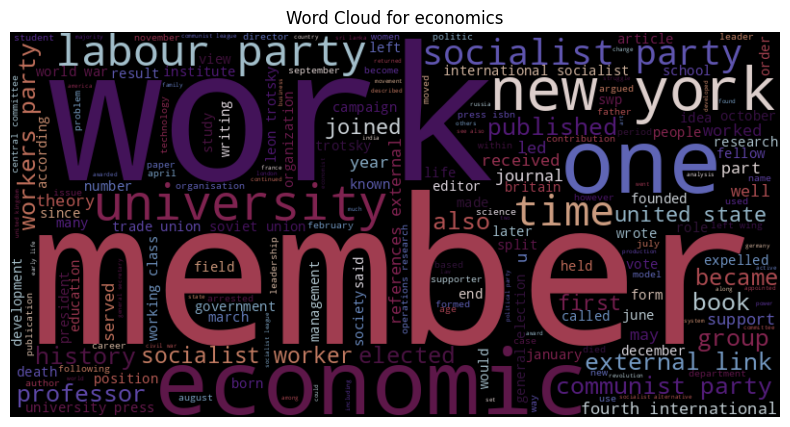

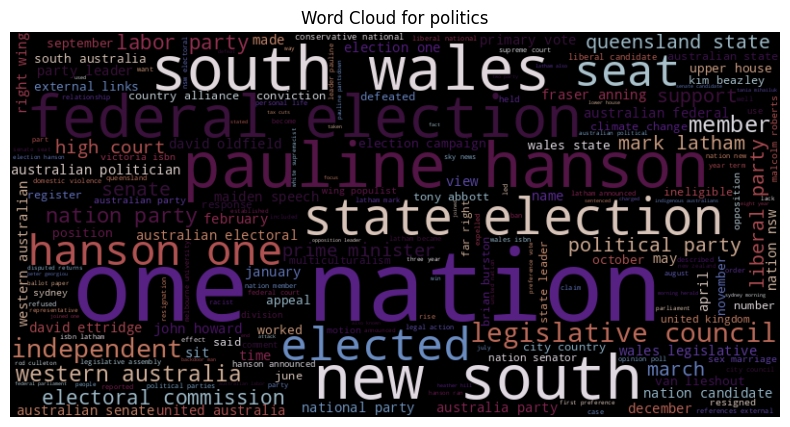

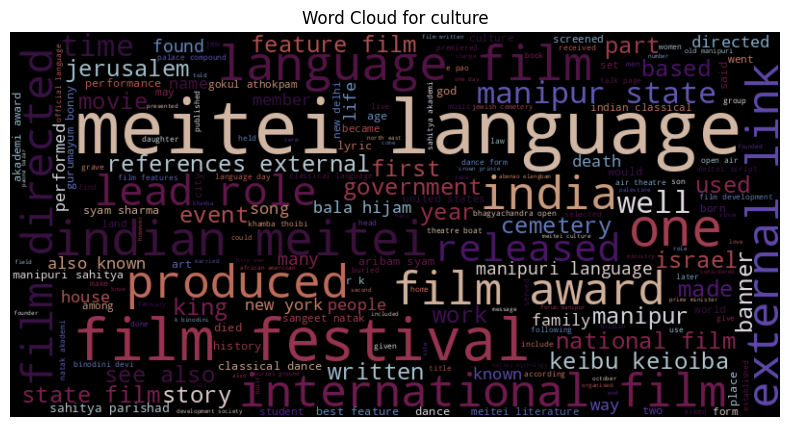

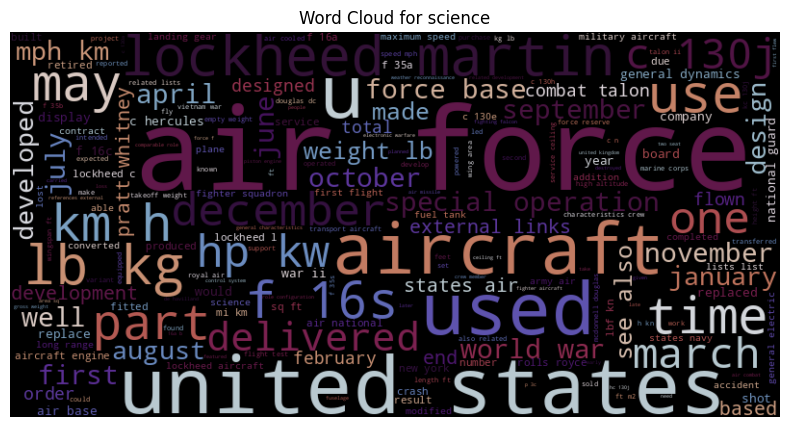

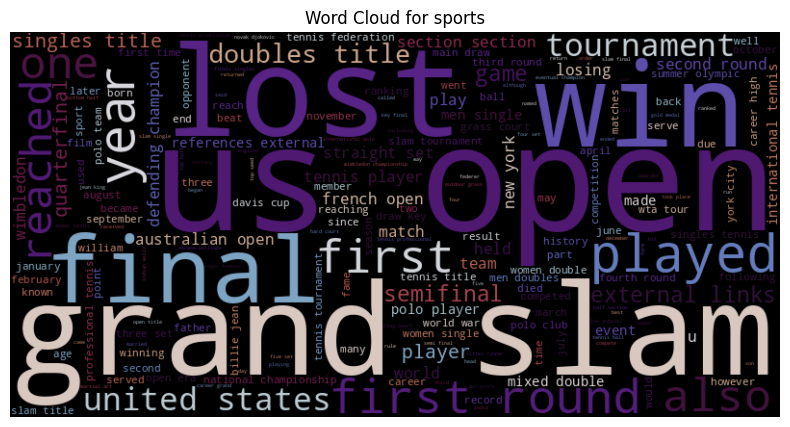

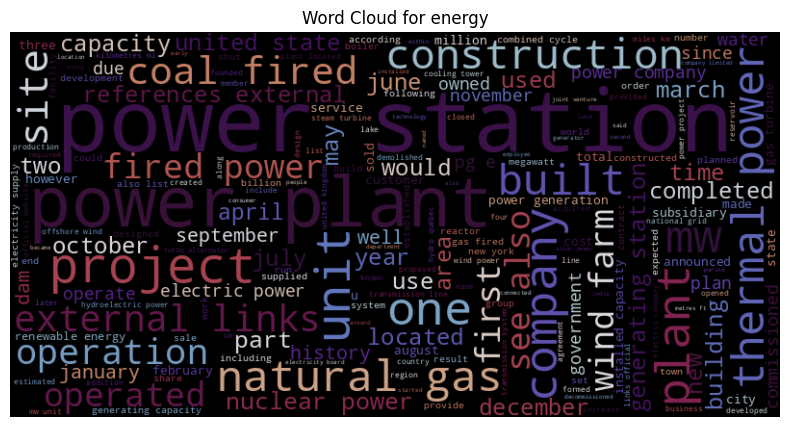

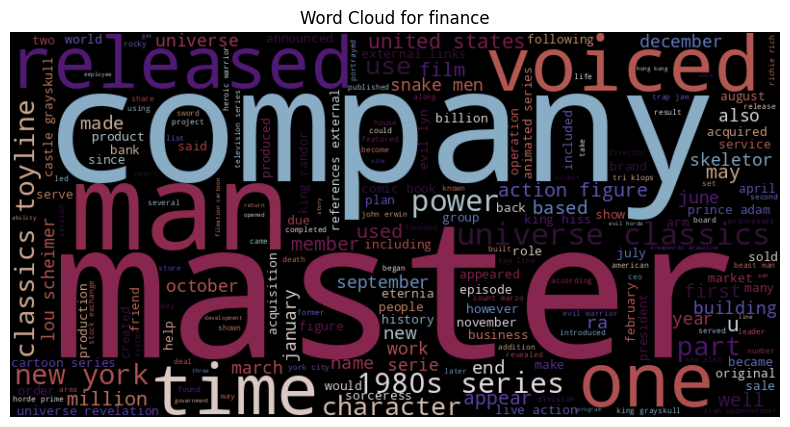

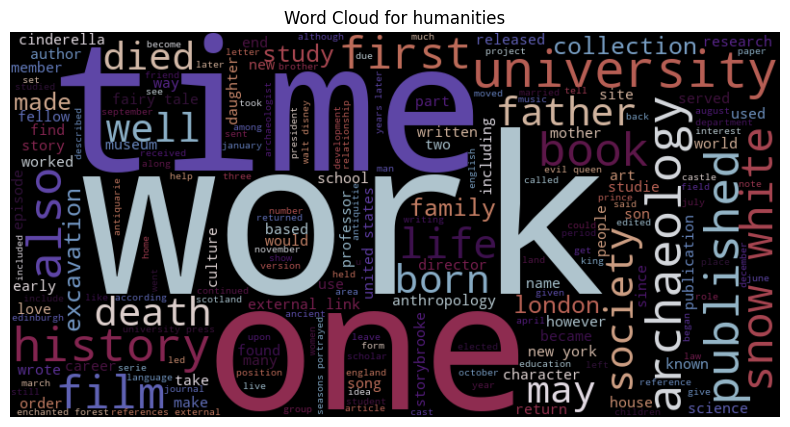

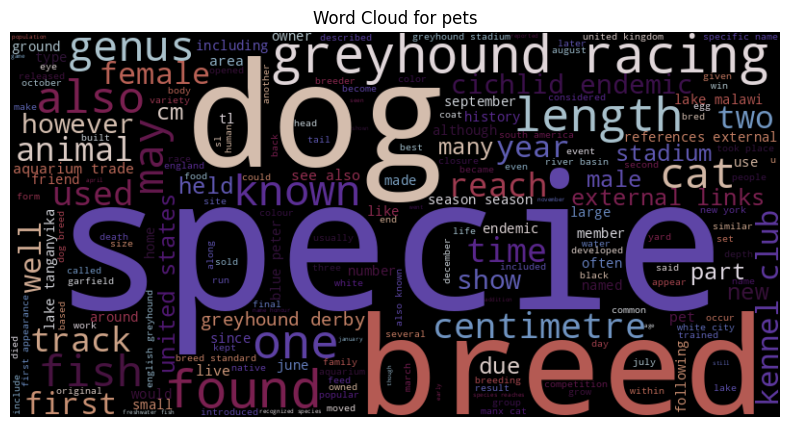

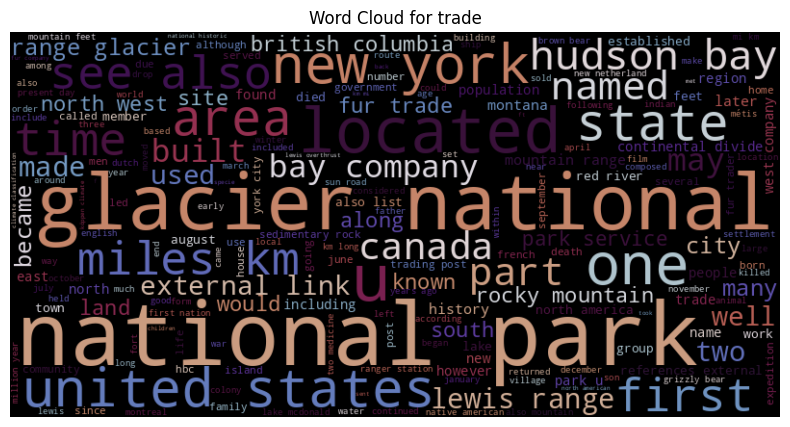

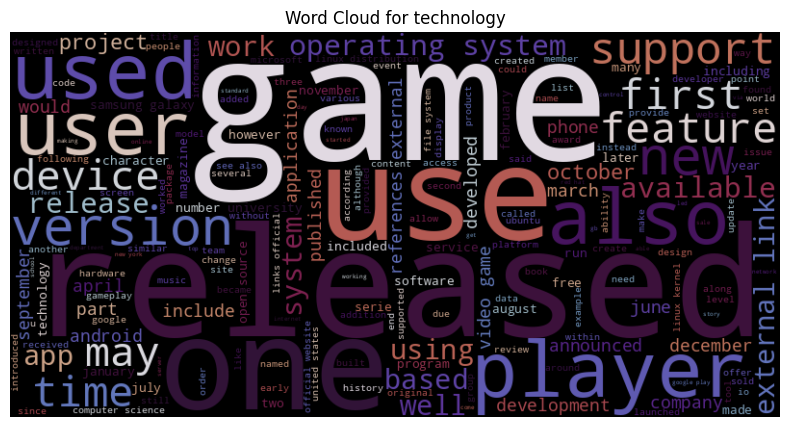

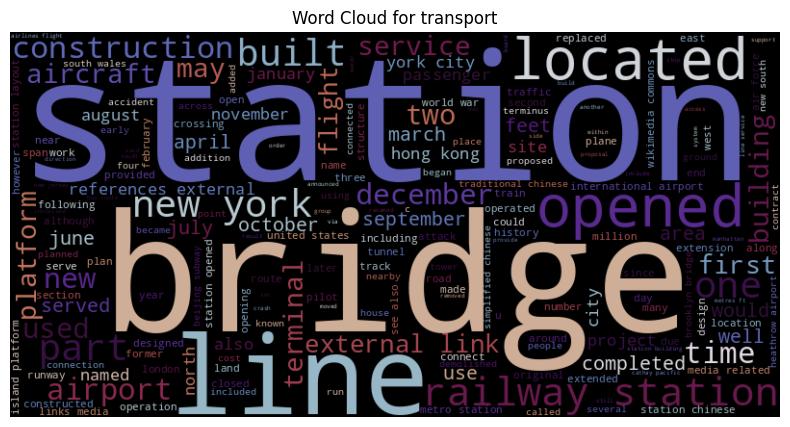

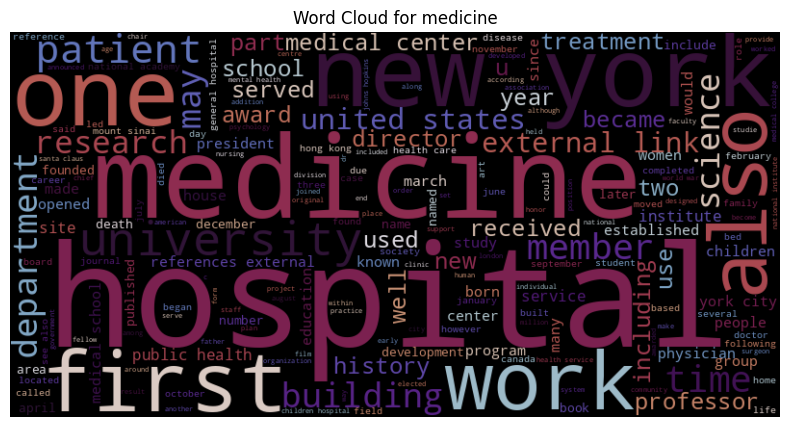

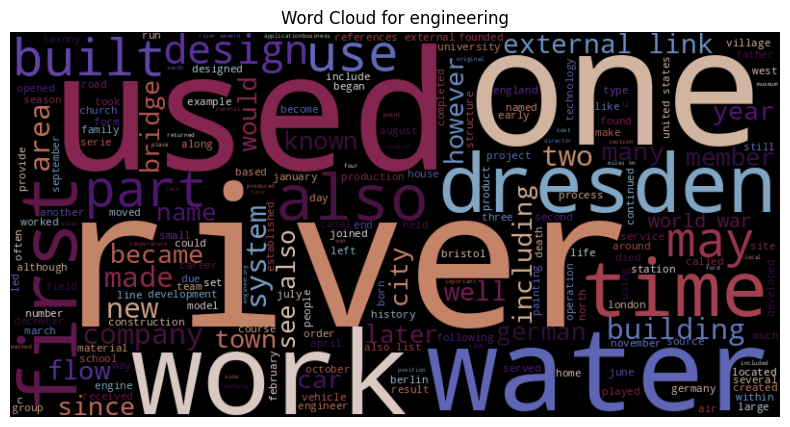

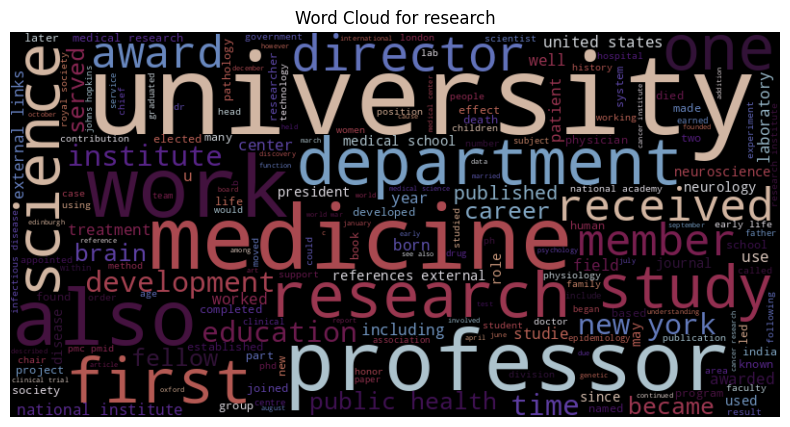

In [0]:
# Loop through Unique Categories
for category in df_cw.select('categoria').distinct().collect():    #retrieves unique values using distinct() and collects them into a list of rows using collect()
    # Join with a space the sum_doc values of the rows collected by filtering the DataFrame to include only those in which the category column matches the current category in the loop.
    text = " ".join(row.sum_doc for row in df_cw.filter(df_cw.categoria == category.categoria).select("sum_doc").collect())

    # Generate Word Cloud
    wordcloud = WordCloud(width=800, height=400, colormap='twilight', stopwords=stopwords_default).generate(text)
    
    # Display Word Cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {category['categoria']}")
    plt.show()

# **Classification**

## *Useful Functions*

In [0]:
def evaluate_model(predictions: DataFrame, labelCol: str = 'target', predictionCol: str = 'prediction') -> Dict[str, float]:
    """
    Evaluate the given predictions using multiple metrics.

    Args:
        predictions (DataFrame): The predictions DataFrame.
        labelCol (str): The name of the label column.
        predictionCol (str): The name of the prediction column.

    Returns:
        Dict[str, float]: A dictionary with evaluation metrics and their respective values.
    """
    metrics = ['accuracy', 'f1']
    results = {}

    for metric in metrics:
        evaluator = MulticlassClassificationEvaluator(labelCol=labelCol, predictionCol=predictionCol, metricName=metric)
        results[metric] = np.round(evaluator.evaluate(predictions), 4)

    return results


def pipe_transf(inputCol: str, model_type) -> Pipeline:
    """
    Create a pipeline for text processing and model training.

    Args:
        inputCol (str): The name of the input column containing text.
        model_type: The type of model to be used in the pipeline.

    Returns:
        Pipeline: A Spark ML pipeline.
    """
    tokenizer = Tokenizer(inputCol=inputCol, outputCol='tokens')
    remover = StopWordsRemover(inputCol='tokens', outputCol='filtered_tokens', stopWords=stopwords_default)
    counter = CountVectorizer(inputCol='filtered_tokens', outputCol='counter_features')
    scaler = StandardScaler(inputCol='counter_features', outputCol='scaled_features')
    modeler = model_type(featuresCol='scaled_features', labelCol='target')
    pipe = Pipeline(stages=[tokenizer, remover, counter, scaler, modeler])

    return pipe


def fit_and_transform(pipe: Pipeline, train: DataFrame, test: DataFrame) -> (DataFrame, DataFrame):
    """
    Fit the pipeline to the training data and transform both training and test data.

    Args:
        pipe (Pipeline): The Spark ML pipeline.
        train (DataFrame): The training DataFrame.
        test (DataFrame): The test DataFrame.

    Returns:
        (DataFrame, DataFrame): Transformed training and test DataFrames.
    """
    model = pipe.fit(train)
    pred_train = model.transform(train)
    pred_test = model.transform(test)

    return pred_train, pred_test


def print_evaluation(pred_train: DataFrame, pred_test: DataFrame):
    """
    Print evaluation metrics for both training and test data.

    Args:
        pred_train (DataFrame): Transformed training DataFrame with predictions.
        pred_test (DataFrame): Transformed test DataFrame with predictions.
    """
    evaluation_results_train = evaluate_model(pred_train)
    print("Training Data Evaluation:")
    for metric, value in evaluation_results_train.items():
        print(f"{metric.capitalize()}: {value:.3f}")

    evaluation_results_test = evaluate_model(pred_test)
    print("\nTest Data Evaluation:")
    for metric, value in evaluation_results_test.items():
        print(f"{metric.capitalize()}: {value:.3f}")

## *Data Pre-Processing*

In [0]:
# Convert Categorical String Values into numerical Indices.
indexer = StringIndexer(inputCol='categoria', outputCol='target')
df_class = indexer.fit(df_cw).transform(df_cw)

# Shows the Indexing by matching the Categories with the obtained Indexes.
target = df_class.select('categoria', 'target').distinct().orderBy('target')
display(target)

categoria target politics 0.0 culture 1.0 humanities 2.0 science 3.0 engineering 4.0 finance 5.0 transport 6.0 economics 7.0 technology 8.0 medicine 9.0 sports 10.0 trade 11.0 energy 12.0 research 13.0 pets 14.0

In [0]:
# Dataset division into train and test
train, test = df_class.randomSplit([0.8, 0.2], seed=0)

## *Model training*

### *Running the pipeline for the 'summary' column*

In [0]:
pipe_sum = pipe_transf('summary', LogisticRegression)

In [0]:
pred_train_sum, pred_test_sum = fit_and_transform(pipe_sum, train, test)

#### *Results*

In [0]:
print_evaluation(pred_train_sum, pred_test_sum)

Training Data Evaluation:
Accuracy: 0.989
F1: 0.989

Test Data Evaluation:
Accuracy: 0.916
F1: 0.916


### *Running the pipeline for the 'documents' column*

In [0]:
pipe_doc = pipe_transf('documents', LogisticRegression)

In [0]:
pred_train_doc, pred_test_doc = fit_and_transform(pipe_doc, train, test)

#### *Results*

In [0]:
print_evaluation(pred_train_doc, pred_test_doc)

Training Data Evaluation:
Accuracy: 0.988
F1: 0.988

Test Data Evaluation:
Accuracy: 0.930
F1: 0.930


# **Conclusions**

The model performs better on the “Documents” column than on the “Summary” column in the test data. 
The higher accuracy in “Documents” could be due to the fact that the model has more data on which to base its decisions (more words and context), reducing the ambiguity that might exist in a short summary.
Given the relatively small discrepancy between performance on the training and test data, we can confirm that the model has good generalization ability, in both cases but especially for the “Documents” column.
Thus, it would be more advantageous to use the entire document for categorization whenever possible.